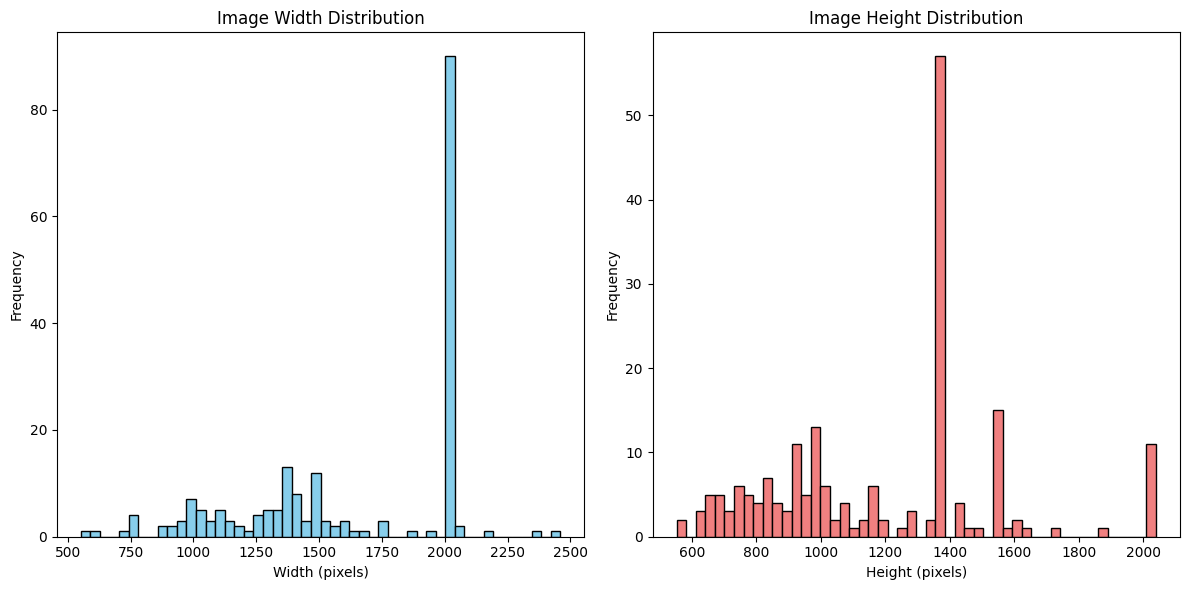

In [1]:
import os
from PIL import Image

import matplotlib.pyplot as plt

def analyze_image_resolutions(directory):
    """
    Analyzes image resolutions in a directory and plots a histogram.

    Args:
        directory (str): The path to the directory containing images.
    """
    resolutions = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Add more extensions if needed
            try:
                filepath = os.path.join(directory, filename)
                with Image.open(filepath) as img:
                    width, height = img.size
                    resolutions.append((width, height))
            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if not resolutions:
        print("No images found in the directory.")
        return

    # Separate widths and heights for histogram plotting
    widths, heights = zip(*resolutions)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=50, color='lightcoral', edgecolor='black')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Specify the directory to analyze
directory_path = '/media/hdd/sonwe1e/Competition/ImageSuperResolution/DF2K/valid'  # Replace with your actual path

# Run the analysis
analyze_image_resolutions(directory_path)